In [129]:
# INITIAL SETUP
import os
import sys

if os.path.basename(os.getcwd()) == "testing":
    os.chdir(os.path.dirname(os.getcwd()))
    sys.path.append(os.getcwd())

import numpy as np
import torch
from lossless.component.coolchic import CoolChicEncoder
from lossless.configs.config import args, str_args
from lossless.training.loss import loss_function
from lossless.training.manager import ImageEncoderManager
from lossless.training.train import train
from lossless.util.command_line_args_loading import load_args
from lossless.util.image_loading import load_image_as_tensor
from lossless.util.logger import TrainingLogger
from lossless.util.parsecli import get_coolchic_param_from_args

torch.autograd.set_detect_anomaly(True)
torch.set_float32_matmul_precision("high")
torch.use_deterministic_algorithms(True)

# ==========================================================================================
# LOAD COMMAND LINE ARGS AND IMAGE
# ==========================================================================================
command_line_args = load_args(
    notebook_overrides={
        "image_index": 0,
        "encoder_gain": 64,
        "color_space": "YCoCg",
        "use_image_arm": True,
    }
)
im_path = args["input"][command_line_args.image_index]
im_tensor, colorspace_bitdepths = load_image_as_tensor(
    im_path, device="cuda:0", color_space=command_line_args.color_space
)
# ==========================================================================================
# LOAD PRESETS, COOLCHIC PARAMETERS
# ==========================================================================================
image_encoder_manager = ImageEncoderManager(
    preset_name=args["preset"], colorspace_bitdepths=colorspace_bitdepths
)

encoder_param = get_coolchic_param_from_args(
    args,
    "lossless",
    image_size=(im_tensor.shape[2], im_tensor.shape[3]),
    use_image_arm=command_line_args.use_image_arm,
    encoder_gain=command_line_args.encoder_gain,
)
coolchic = CoolChicEncoder(param=encoder_param)
coolchic.load_state_dict(
    torch.load(
        "../logs/full_runs/2026_01_04_default_name/trained_models/2026_01_04__22_39_01__trained_coolchic_kodak_kodim01_img_rate_3.800624370574951.pth"
    )
)

coolchic.eval()
coolchic.training
with torch.no_grad():
    raw_synth_out, decoder_side_latent = coolchic.get_latents_raw_synth_out()
    print("raw_synth_out:", raw_synth_out.shape)
    print("flat_decoder_side_latent:", len(decoder_side_latent))

Converting image to YCoCg color space
raw_synth_out: torch.Size([1, 6, 512, 768])
flat_decoder_side_latent: 7


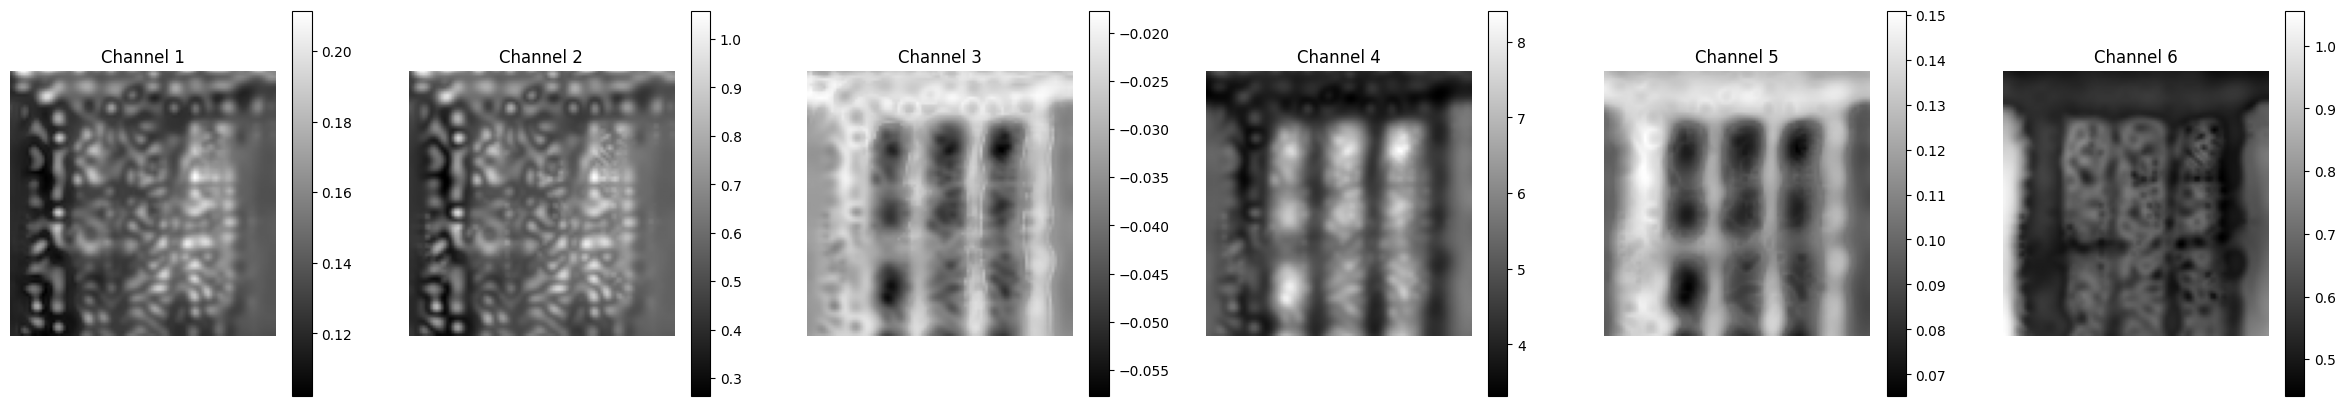

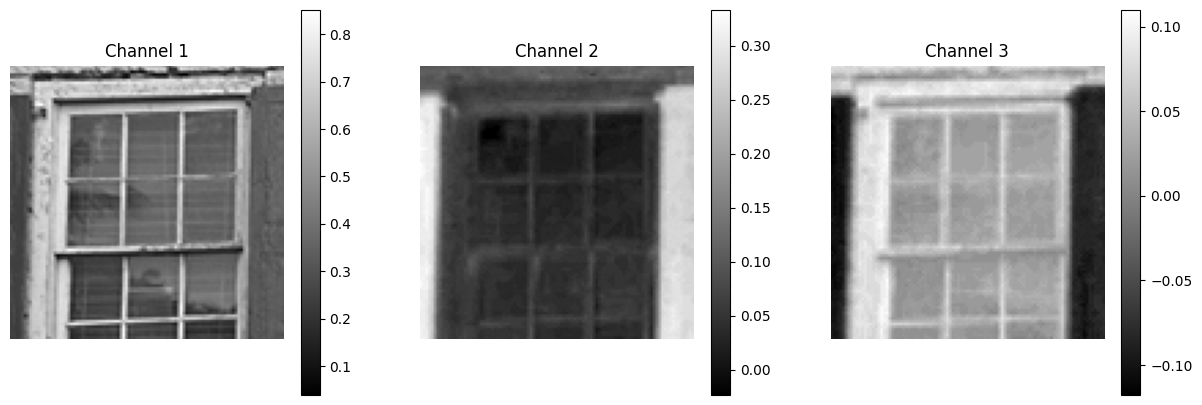

In [130]:
# CROP IMAGE AND PLOT CHANNELS
import matplotlib.pyplot as plt

def plot_image_by_channels(image_tensor: torch.Tensor):
    image_np = image_tensor[0].permute(1, 2, 0).cpu().numpy()
    num_channels = image_np.shape[2]
    fig, axes = plt.subplots(1, num_channels, figsize=(5 * num_channels, 5))
    for i in range(num_channels):
        ax = axes[i]  # type: ignore
        im = ax.imshow(image_np[:, :, i], cmap="gray")
        ax.set_title(f"Channel {i+1}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    plt.show()

tmp_off, tmp_size = 28, 100
offset_x, offset_y, width, height = tmp_off, tmp_off, tmp_size, tmp_size
reduced_raw_synth_out = torch.clone(raw_synth_out[:, :, offset_y:offset_y+height, offset_x:offset_x+width].to("cpu"))
reduced_im_tensor = torch.clone(im_tensor[:, :, offset_y:offset_y+height, offset_x:offset_x+width].to("cpu"))
coolchic.to_device("cpu")
plot_image_by_channels(reduced_raw_synth_out)
plot_image_by_channels(reduced_im_tensor)

In [122]:
import constriction
import lossless.util.color_transform as color_transform
import torch
from lossless.io.distributions import calculate_probability_distribution
from lossless.io.encoding_interfaces.base_interface import EncodeDecodeInterface
from lossless.io.types import POSSIBLE_ENCODING_DISTRIBUTIONS
import struct

testing_stop = 10


def encode_with_predictor(
    enc_dec_interface: EncodeDecodeInterface,
    distribution: POSSIBLE_ENCODING_DISTRIBUTIONS = "logistic",
    output_path="./test-workdir/encoder_size_test/coolchic_encoded_image.binary",
):
    enc_dec_interface.reset_iterators()

    enc = constriction.stream.stack.AnsCoder()  # type: ignore
    bits_theoretical = 0

    with torch.no_grad():
        symbols_to_encode = []
        prob_distributions = []
        raw_values_of_symbols_to_encode = []
        channel_indices = []
        while True:
            try:
                features = enc_dec_interface.get_next_predictor_features()
                mu, scale = enc_dec_interface.get_pdf_parameters(features)
                ch_ind = enc_dec_interface.get_channel_idx()
                # print(features)
                # print(mu, scale)
                # print(f"ch_ind: {ch_ind}")
                channel_indices.append(ch_ind)
                prob_distributions.append(
                    calculate_probability_distribution(
                        mu
                        - enc_dec_interface.ct_range.ranges_int[ch_ind][0]
                        / enc_dec_interface.ct_range.scaling_factors[ch_ind],
                        scale,
                        color_bitdepths=enc_dec_interface.ct_range,
                        distribution=distribution,
                        channel_idx=ch_ind,
                    )
                )
                raw_values_of_symbols_to_encode.append(enc_dec_interface.get_current_element_int())
                symbols_to_encode.append(
                    raw_values_of_symbols_to_encode[-1]
                    - enc_dec_interface.ct_range.ranges_int[ch_ind][0]
                )
                bits_theoretical += -torch.log2(
                    prob_distributions[-1][symbols_to_encode[-1]]
                ).item()
                enc_dec_interface.advance_iterators(testing_stop=testing_stop)
            except StopIteration:
                break

        for symbol_index, symbol_to_encode, prob_distribution in zip(
            list(range(len(symbols_to_encode))),
            reversed(symbols_to_encode),
            reversed(prob_distributions),
        ):
            model = constriction.stream.model.Categorical(  # type: ignore
                prob_distribution.detach().cpu().numpy(), perfect=False
            )
            try:
                enc.encode_reverse(symbol_to_encode, model)
            except Exception as e:
                print(f"probability: {prob_distribution}")
                print(f"Error encoding symbol {symbol_to_encode} at index {symbol_index}")
                raise e

    bitstream = enc.get_compressed()
    bitstream.tofile(output_path)
    with open(output_path, "rb") as f:
        original_data = f.read()
    with open(output_path, "wb") as f:
        # Pack two 32-bit integers into binary
        f.write(enc_dec_interface.get_packing_parameters())
        f.write(original_data)

    print(f"Theoretical bits per sub pixel: {bits_theoretical/len(symbols_to_encode)}")

    return bitstream, raw_values_of_symbols_to_encode, prob_distributions, channel_indices


def decode_quick_check(
    prob_distributions: list[torch.Tensor],
    channel_indices: list[int],
    bitstream_path: str = "./test-workdir/encoder_size_test/coolchic_encoded_image.binary",
    ct: color_transform.ColorBitdepths = color_transform.YCoCgBitdepths(),
    offset: int = 4,
):
    with open(bitstream_path, "rb") as f:
        header = f.read(offset)  # 3 integers * 4 bytes each
        num_symbols = struct.unpack("i" * (offset // 4), header)
    bitstream = np.fromfile(bitstream_path, dtype=np.uint32, offset=offset)
    dec = constriction.stream.stack.AnsCoder(bitstream)  # type: ignore

    decoded_symbols = []
    with torch.no_grad():
        for i, prob_distribution in enumerate(prob_distributions):
            prob_array = prob_distribution.detach().cpu().flatten().numpy()
            model = constriction.stream.model.Categorical(prob_array, perfect=False)  # type: ignore
            decoded_char = (
                torch.tensor(dec.decode(model, 1)[0]) + ct.ranges_int[channel_indices[i]][0]
            )
            decoded_symbols.append(decoded_char.item())
    return decoded_symbols


def decode_with_predictor(
    enc_dec_interface: EncodeDecodeInterface,
    bitstream_path: str = "./test-workdir/encoder_size_test/coolchic_encoded_image.binary",
    distribution: POSSIBLE_ENCODING_DISTRIBUTIONS = "logistic",
):
    enc_dec_interface.reset_iterators()
    with open(bitstream_path, "rb") as f:
        offset = enc_dec_interface.set_packing_parameters(f)
    print(f"offset: {offset}")
    bitstream = np.fromfile(bitstream_path, dtype=np.uint32, offset=offset)
    dec = constriction.stream.stack.AnsCoder(bitstream)  # type: ignore

    with torch.no_grad():
        symbols_decoded = []
        prob_distributions = []
        while True:
            try:
                features = enc_dec_interface.get_next_predictor_features()
                mu, scale = enc_dec_interface.get_pdf_parameters(features)
                ch_ind = enc_dec_interface.get_channel_idx()
                # print(features)
                # print(mu, scale)
                # print(f"ch_ind: {ch_ind}")
                prob_distributions.append(
                    calculate_probability_distribution(
                        mu
                        - enc_dec_interface.ct_range.ranges_int[ch_ind][0]
                        / enc_dec_interface.ct_range.scaling_factors[ch_ind],
                        scale,
                        color_bitdepths=enc_dec_interface.ct_range,
                        distribution=distribution,
                        channel_idx=ch_ind,
                    )
                )
                model = constriction.stream.model.Categorical(  # type: ignore
                    prob_distributions[-1].detach().cpu().numpy(), perfect=False
                )
                symbols_decoded.append(
                    (
                        torch.tensor(dec.decode(model, 1)[0])
                        + enc_dec_interface.ct_range.ranges_int[ch_ind][0]
                    ).item()
                )
                enc_dec_interface.set_decoded_element(
                    symbols_decoded[-1] / enc_dec_interface.ct_range.scaling_factors[ch_ind]
                )
                enc_dec_interface.advance_iterators(testing_stop=testing_stop)
            except StopIteration:
                break
    return symbols_decoded, prob_distributions

In [120]:
from _io import BufferedReader
from lossless.io.encoding_interfaces.base_interface import EncodeDecodeInterface
from lossless.util.color_transform import ColorBitdepths


class ImageEncodeDecodeInterface(EncodeDecodeInterface):
    def __init__(self, data: tuple, model: CoolChicEncoder, ct_range: ColorBitdepths) -> None:
        # raw image data is a tensor of shape [1, C, H, W]
        self.raw_image_data = data[0]
        # raw synth out is a tensor of shape [1, S, H, W]
        self.raw_synth_out = data[1]
        self.model: CoolChicEncoder = model
        self.ct_range = ct_range
        self.current_spatial_pos = [0, 0, 0, 0]
        self.header_size = 12  # H, W, C

    def reset_iterators(self) -> None:
        self.current_spatial_pos = [0, 0, 0, 0]

    def _iterator_to_flat_index(self) -> int:
        flat_index = 0
        nested_multiplier = 1
        b, c, h, w = self.raw_image_data.shape
        dim_sizes = [b, h, w, c]
        b_cur, c_cur, h_cur, w_cur = self.current_spatial_pos
        spatial_pos_permuted = [b_cur, h_cur, w_cur, c_cur]
        
        for dim in range(len(self.current_spatial_pos) - 1, -1, -1):
            flat_index += spatial_pos_permuted[dim] * nested_multiplier
            nested_multiplier *= dim_sizes[dim]
        return flat_index

    def _flat_index_to_iterator(self, flat_index: int) -> list[int]:
        res = [0, 0, 0, 0]
        b, c, h, w = self.raw_image_data.shape
        dim_sizes = [b, h, w, c]
        for dim in range(len(self.current_spatial_pos) - 1, -1, -1):
            res[dim] = flat_index % dim_sizes[dim]
            flat_index = flat_index // dim_sizes[dim]
        b, h, w, c = res
        res = [b, c, h, w]
        return res

    def advance_iterators(self, testing_stop: int = -1) -> None:
        flat_index = self._iterator_to_flat_index()
        flat_index += 1
        if testing_stop > 0 and flat_index > testing_stop:
            raise StopIteration("Partial stop for testing.")
        if flat_index >= self.raw_image_data.numel():
            raise StopIteration("All pixels have been processed.")
        # compute new spatial pos from flat index
        self.current_spatial_pos = self._flat_index_to_iterator(flat_index)

    def get_next_predictor_features(self) -> torch.Tensor:
        b, c, h, w = self.current_spatial_pos
        im_r = self.raw_image_data[b, 0, :, :]
        im_g = self.raw_image_data[b, 1, :, :]
        im_b = self.raw_image_data[b, 2, :, :]
        context_r = self.model.image_arm.get_neighbor_context(im_r, h=h, w=w).flatten()
        context_g = self.model.image_arm.get_neighbor_context(im_g, h=h, w=w).flatten()
        context_b = self.model.image_arm.get_neighbor_context(im_b, h=h, w=w).flatten()
        context = torch.cat([context_r, context_g, context_b], dim=0)[None, :]
        r_syn_o = self.raw_synth_out[b, :, h, w]
        im_known = self.raw_image_data[b, :c, h, w]
        full_feature = torch.cat([context, r_syn_o[None, :], im_known[None, :]], dim=1)
        return full_feature

    def get_pdf_parameters(self, features: torch.Tensor) -> tuple:
        current_channel = self.get_channel_idx()
        _, _, h, w = self.current_spatial_pos

        cutoffs = [
            sum(self.model.image_arm.params.synthesis_out_params_per_channel[:i])
            for i in range(len(self.model.image_arm.params.synthesis_out_params_per_channel) + 1)
        ]
        start_idx = cutoffs[current_channel] + self.model.image_arm.params.context_size * 3
        end_idx = cutoffs[current_channel + 1] + self.model.image_arm.params.context_size * 3
        relevant_raw_synth_out = features[:, start_idx:end_idx]

        image_arm_out = self.model.image_arm.inference_at_position(
            h,
            w,
            features,
            relevant_raw_synth_out,
            current_channel,
        )
        # mu, log_scale = torch.chunk(image_arm_out, 2, dim=1)
        mu, scale = self.model.proba_output(image_arm_out, self.raw_image_data)
        return mu[0, 0], scale[0, 0]

    def get_current_element(self):
        b, c, h, w = self.current_spatial_pos
        return self.raw_image_data[b, c, h, w]

    def get_current_element_int(self) -> int:
        b, c, h, w = self.current_spatial_pos
        return (
            self.raw_image_data[b, c, h, w] * self.ct_range.scaling_factors[c]
        ).int().item()

    def set_decoded_element(self, element) -> None:
        b, c, h, w = self.current_spatial_pos
        self.raw_image_data[b, c, h, w] = element

    def get_packing_parameters(self) -> bytes:
        b, c, h, w = self.raw_image_data.shape
        return struct.pack("iii", h, w, c)

    def set_packing_parameters(self, bitstream: BufferedReader) -> int:
        header = bitstream.read(self.header_size)
        (h, w, c) = struct.unpack("iii", header)
        self.raw_image_data = torch.zeros((1, c, h, w), device="cpu", dtype=torch.float32)
        return self.header_size

    def get_channel_idx(self) -> int:
        return self.current_spatial_pos[1]

In [37]:
print((reduced_im_tensor * 255).int())

tensor([[[[148, 146, 161, 171, 166, 142],
          [165, 151, 133, 161, 174, 171],
          [174, 165, 146, 139, 156, 169],
          [ 85,  85,  89,  86,  90,  87],
          [ 91,  96, 108, 109, 121, 135],
          [175, 171, 163, 167, 173, 172]],

         [[ 25,  24,  24,  25,  25,  26],
          [ 26,  27,  27,  26,  27,  27],
          [ 29,  28,  28,  28,  29,  28],
          [ 28,  28,  26,  26,  26,  26],
          [ 25,  25,  24,  24,  23,  26],
          [ 25,  25,  24,  24,  24,  26]],

         [[ 21,  21,  20,  21,  21,  18],
          [ 19,  19,  19,  18,  19,  19],
          [ 20,  17,  17,  17,  18,  17],
          [ 13,  13,  12,  12,  12,  16],
          [  9,   9,  10,  11,  11,  12],
          [ 13,  13,  15,  15,  14,  15]]]], dtype=torch.int32)


In [128]:
testing_stop = -1
# reduced_im_tensor = torch.ones_like(reduced_im_tensor)
# reduced_im_tensor[:, 1] *= 2
# reduced_im_tensor[:, 2] *= 3
# reduced_im_tensor /= 255
# reduced_raw_synth_out = torch.zeros_like(reduced_raw_synth_out)

encode_decode_interface = ImageEncodeDecodeInterface(
    data=(torch.clone(reduced_im_tensor), torch.clone(reduced_raw_synth_out)), model=coolchic, ct_range=colorspace_bitdepths
)
bitstream, symbols_to_encode, prob_distributions_enc, channel_indices = encode_with_predictor(
    enc_dec_interface=encode_decode_interface,
    distribution="logistic",
    output_path="./test-workdir/encoder_size_test/coolchic_encoded_image.binary",
)
quick_symbols_decoded = decode_quick_check(
    prob_distributions=prob_distributions_enc,
    bitstream_path="./test-workdir/encoder_size_test/coolchic_encoded_image.binary",
    ct=colorspace_bitdepths,
    offset=encode_decode_interface.header_size,
    channel_indices=channel_indices,
)

symbols_decoded, prob_distributions_dec = decode_with_predictor(
    enc_dec_interface=encode_decode_interface,
    distribution="logistic",
    bitstream_path="./test-workdir/encoder_size_test/coolchic_encoded_image.binary",
)
# print(f"symbols to encode: {symbols_to_encode}")
# print(f"quickdecoded_symb: {quick_symbols_decoded}")
# print(f"symbols decoded:   {symbols_decoded}")
symbols_enc_tensor = torch.tensor(symbols_to_encode)
symbols_dec_tensor = torch.tensor(symbols_decoded)
assert torch.equal(symbols_enc_tensor, symbols_dec_tensor), "Decoded symbols do not match encoded symbols!"

Theoretical bits per sub pixel: 13.44284309498469
offset: 12


In [131]:
encode_decode_interface = ImageEncodeDecodeInterface(
    data=(torch.clone(reduced_im_tensor), torch.clone(reduced_raw_synth_out)), model=coolchic, ct_range=colorspace_bitdepths
)
print((encode_decode_interface.raw_image_data * 255).int())

tensor([[[[148, 146, 161,  ...,  86, 100,  88],
          [165, 151, 133,  ...,  85, 107, 103],
          [174, 165, 146,  ..., 149, 151, 160],
          ...,
          [ 62,  64,  58,  ...,  79,  80,  83],
          [ 63,  65,  58,  ...,  75,  77,  73],
          [ 61,  63,  58,  ...,  76,  81,  83]],

         [[ 25,  24,  24,  ...,  28,  30,  27],
          [ 26,  27,  27,  ...,  30,  30,  30],
          [ 29,  28,  28,  ...,  31,  32,  32],
          ...,
          [ 81,  78,  79,  ...,  71,  75,  73],
          [ 80,  78,  79,  ...,  72,  75,  75],
          [ 80,  80,  79,  ...,  73,  75,  75]],

         [[ 21,  21,  20,  ...,  10,  11,  11],
          [ 19,  19,  19,  ...,  11,  12,  12],
          [ 20,  17,  17,  ...,  10,  13,  14],
          ...,
          [-24, -26, -25,  ..., -22, -22, -20],
          [-25, -26, -25,  ..., -24, -21, -21],
          [-24, -25, -25,  ..., -23, -21, -22]]]], dtype=torch.int32)
